In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from statistics import mean
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import logging
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.neural_network import MLPClassifier
import time


In [23]:
import logging

# create logger with 'spam_application'
logger = logging.getLogger('spam_application')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('risultati.log')
fh.setLevel(logging.INFO)
logger.addHandler(fh)



In [24]:
def addestraSVC(nomeDataset, X, y, c, gamma, kernel, dim):

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30, stratify=y)
    
    #standardizzo i dati
    sc = StandardScaler()
    X_train_standardizzato = sc.fit_transform(X_train)
    X_test_standardizzato = sc.fit_transform(X_test)
    
    #applico la riduzione della dimensionalita'
    pca = PCA(n_components=dim)
    
    X_train_ridotto = pca.fit_transform(X_train_standardizzato)
    X_test_ridotto = pca.fit_transform(X_test_standardizzato)
    
    #addestro la SVC
    model = SVC(gamma = gamma, C=c, kernel = kernel)
    model.fit(X_train_ridotto, y_train)
    
    y_pred = model.predict(X_test_ridotto)
    
    #calcolo lo score
    scoreStandardizzato = accuracy_score(y_test, y_pred)
    
    #Non standardizzo i  dati ma riduco subito la dimensionalita' e addestro la SVC
    X_train_ridotto = pca.fit_transform(X_train)
    X_test_ridotto = pca.fit_transform(X_test)
    
    model = SVC(gamma = gamma, C=c, kernel = kernel)
    model.fit(X_train_ridotto, y_train)
    
    y_pred_not_standardizzato = model.predict(X_test_ridotto)
    
    #calcolo lo score
    score_not_standardizzato = accuracy_score(y_test, y_pred_not_standardizzato)
     
    if scoreStandardizzato > score_not_standardizzato:
        plot_confusion_matrix(y_test, y_pred)
        plt.show()
        logger.info(f'Addestrato {nomeDataset} standardizzando i dati con una SVC con uno score di {scoreStandardizzato} e iperparametri: C {c}, gamma {gamma}, kernel {kernel}, numero dimensioni {dim}')
        return(f'Lo score e stato calcolato standardizzando i dati, score: {scoreStandardizzato}')
    else:
        plot_confusion_matrix(y_test, y_pred_not_standardizzato)
        plt.show()
        logger.info(f'Addestrato {nomeDataset} con una SVC con uno score {score_not_standardizzato} e iperparametri: C {c}, gamma {gamma}, kernel {kernel}, numero dimensioni {dim}')
        return(f'Lo score e stato calcolato non standardizzando i dati, score: {score_not_standardizzato}')

    
def addestraMLPClassifierLBFGS(nomeDataset, X, y, activation, dim, hidden_layer_sizes, max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30, stratify=y)
    
    sc = StandardScaler()
    
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    pca = PCA(n_components=dim)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)
    
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver='lbfgs', max_iter=max_iter, activation=activation)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)

    plot_confusion_matrix(y_test, y_pred)
    plt.show()
    logger.info(f'Addestrato {nomeDataset} usando MLP come algoritmo di apprendimento con funzione di attivazione: {activation} solver: lbfgs iterazioni massime: {max_iter} hidden_layer_sizes: {hidden_layer_sizes} e dimensione {dim}')
    return(f'Score: {score}')

def addestraMLPClassifier(nomeDataset, solver, learning_rate, learning_rate_init, X, y, activation, dim, hidden_layer_sizes, max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=30, stratify=y)
    
    sc = StandardScaler()
    
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    pca = PCA(n_components=dim)
    
    X_train = pca.fit_transform(X_train)
    X_test = pca.fit_transform(X_test)
    
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, solver=solver, learning_rate=learning_rate, learning_rate_init=learning_rate_init, max_iter=max_iter, activation=activation)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)

    plot_confusion_matrix(y_test, y_pred)
    plt.show()
    logger.info(f'Addestrato {nomeDataset} usando MLP come algoritmo di apprendimento con funzione di attivazione: {activation} solver: lbfgs iterazioni massime: {max_iter} hidden_layer_sizes: {hidden_layer_sizes} e dimensione {dim}')
    return(f'Score: {score}')


def trovaIperparametri(X, y, model, numero_dimensioni):
    
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)

    if model == SVC:
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('SVM', SVC()), 
        ]

        pipeline = Pipeline(steps)

        valori_C = np.arange(0.1, 1.0, 0.1)
        valori_gamma = [0.1, 0.01]
        valori_kernel = ['linear', 'poly', 'rbf', 'sigmoid']

        params = { 'SVM__C': valori_C,
                  'SVM__gamma': valori_gamma,
                  'SVM__kernel': valori_kernel,
                  'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                }
    elif model == DecisionTreeClassifier:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('tree', DecisionTreeClassifier()),
        ]
        
        pipeline= Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'tree__criterion': ['gini', 'entropy'],
                 }
    
    elif model == RandomForestClassifier:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('random_forest', RandomForestClassifier()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'random_forest__n_estimators': np.arange(10, 100, 10),
                 }
    
    elif model == LinearDiscriminantAnalysis:
        
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('linear_discriminant_analysis', LinearDiscriminantAnalysis()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),
                  'linear_discriminant_analysis__solver': ['svd', 'lsqr', 'eigen'],
                  
                 }
    elif model == GaussianNB:
        steps = [
            ('scaler', StandardScaler()),
            ('reduce_dim', PCA()),
            ('linear_discriminant_analysis', LinearDiscriminantAnalysis()),
        ]
        
        pipeline = Pipeline(steps)
        
        params = {'reduce_dim__n_components': np.arange(1, numero_dimensioni, 1),

                 }
        
    grid = GridSearchCV(pipeline, param_grid=params, cv=3)
    
    grid.fit(X_train, y_train)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    return grid.best_params_

In [25]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [26]:
X = df.drop('Research', 1)
y = df['Research']

X.shape

(500, 8)

In [ ]:
trovaIperparametri(model=SVC, X=X, y=y, numero_dimensioni=8)

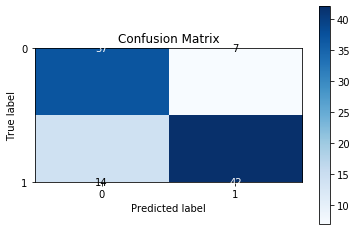

'Lo score e stato calcolato standardizzando i dati, score: 0.79'

In [7]:
addestraSVC('Admission_Predict_Ver1', X=X, y=y, c=0.2, gamma=0.1, kernel='rbf', dim=7)

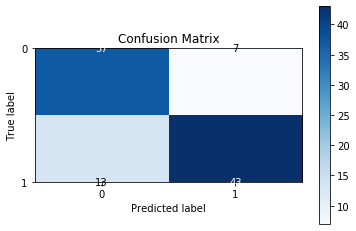

'Lo score e stato calcolato standardizzando i dati, score: 0.8'

In [8]:
addestraSVC('Admission_Predict_Ver1', X=X, y=y, c=0.2, gamma=0.1, kernel='rbf', dim=6)

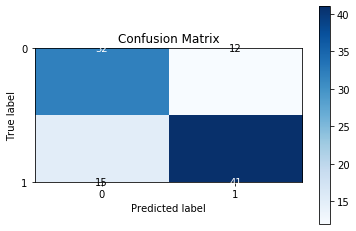

'Score: 0.73'

In [9]:
addestraMLPClassifierLBFGS(activation='logistic', nomeDataset='Admission_Predict_Ver1', hidden_layer_sizes=(13, 13), max_iter=400, X=X, y=y, dim=7)

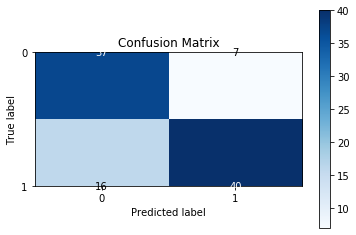

'Score: 0.77'

In [10]:
addestraMLPClassifierLBFGS(activation='relu', nomeDataset='Admission_Predict_Ver1', hidden_layer_sizes=(5, 5), max_iter=500, X=X, y=y, dim=3)

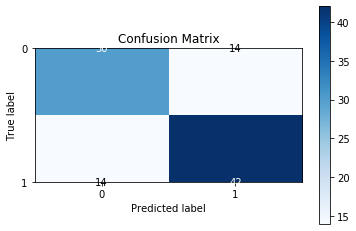

'Score: 0.72'

In [11]:
addestraMLPClassifierLBFGS(activation='relu', nomeDataset='Admission_Predict_Ver1', hidden_layer_sizes=(5, 5), max_iter=500, X=X, y=y, dim=2)

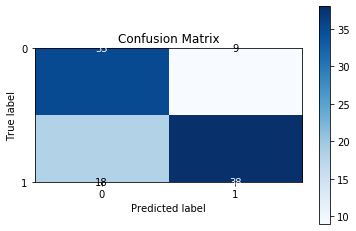

'Score: 0.73'

In [12]:
addestraMLPClassifier(activation='relu', nomeDataset='Admission_Predict_Ver1', solver='sgd', learning_rate='adaptive', learning_rate_init=0.005, hidden_layer_sizes=(5, 5), max_iter=500, X=X, y=y, dim=2)